# Synthesis functions

In [179]:
load_synthesis <- function(fnm) {
    df_in <- read.csv(fnm, sep = " ", comment = "#", header = F, col.names = c("y0", "y1", "est", "lower", "upper", "ci", "model", "m2", "m3"))
    # ideally would set inf/10000 to NA here, but that messes up the comparison with the original synthesis, so not implemented yet
    obs_in <- df_in[df_in$m3 == "",]
    models_in <- df_in[df_in$m3 != "",]

    return(list("obs_in" = obs_in, "models_in" = models_in))

}

In [200]:
prep_window <- function(rc = c(1,1), w = 4, h = 4, ...) { options(repr.plot.width = rc[2]*w, repr.plot.height = rc[1]*h, repr.plot.res = 200); par(mfrow = rc, pch = 20, ...) }

plot_synthesis <- function(synth, xlim, lwd = 7, vline = 0, xlab = "", main = "", add_space = T, take_logs, hide_ylabels = F) {

    if (missing(take_logs)) take_logs <- synth$take_logs
    if (class(synth) == "list") synth <- synth$df

    nobs <- sum(synth$group == "obs")
    nmod <- sum(synth$group == "models")

    if(add_space) {
        yy <- c(rev(0:nobs+nmod+4), rev(0:nmod+2), 0)
    } else {
        yy <- nrow(synth):1
    }

    if (take_logs) {
        log_axs <- "x"
        if (missing(xlim)) xlim <- exp(range(pretty(log(as.numeric(unlist(synth[,c("l_wb", "u_wb")]))))))
    } else {
        log_axs <- ""
        if (missing(xlim)) xlim <- range(pretty(as.numeric(unlist(synth[,c("l_wb", "u_wb")]))))
    }

    
    plot(0, type = "n", xlim = xlim, ylim = range(yy) + c(-0.5,0.5), log = log_axs,
         yaxt = "n", ylab = "", xlab = xlab, main = main)

    grid(ny = NA, col = adjustcolor("black", 0.2), lty = 1)

    gcols = c("obs" = adjustcolor("blue", 0.5),
              "obs_synth" = "blue",
              "models" = adjustcolor("red", 0.5),
              "model_synth" = "red",
              "synth" = "magenta")[synth$group]

    # nb. currently this makes it look like there is uncertainty on the obs even when only one dataset is used
    segments(y0 = yy, x0 = synth$l_wb, x1 = synth$u_wb, lwd = lwd, col = "black", lend = 2)
    segments(y0 = yy, x0 = synth$l_wb, x1 = synth$u_wb, lwd = lwd-2, col = "white", lend = 2)
    segments(y0 = yy, x0 = synth$lower, x1 = synth$upper, lwd = lwd-2, col = gcols, lend = 1)
    points(synth$est, yy, pch = 21, bg = gcols, lwd = 2, cex = lwd/10)

    if(!hide_ylabels) axis(2, at = yy, labels = synth$model, las = 1)  

    abline(v = vline, lty = 2)
}

## Currently implemented on climate explorer

In [181]:
synth_cx <- function(obs_in, models_in, take_logs = F) {

    # load data and split into obs & models
    # df_in = read.csv(synth_fnm, comment.char = "#", header = F, sep = " ")
    # colnames(df_in) <- c("y0", "y1", "est", "lower", "upper", "ci", "model", "m2", "m3")
    # obs_in = df_in[df_in$m2 == "",]
    # models_in = df_in[df_in$m2 != "",]

    #############################################################################################################################################
    ## INTERNAL SUPPORT FUNCTIONS
    
    getsynmean <- function(data, sig_mod = 0) {    
    
        # calculate weight for each model (based on width of confidence interval, so adding 2\sigma_{mrep} in quadrature)
        w = 1/((data$upper - data$lower)^2 + (2*sig_mod)^2) # factor 2 for sig_mod transforms from 2sigma to 4sigma, but this is then sqrted
        w1 = sum(w)
    
        # weighted sum of squares & bounds
        s1 <- sum(w*data$est) / w1
        ss2 <- apply(data[,c("est", "lower", "upper")], 2, function(b) sum((w*(data$est - b))^2))
        ss2 <- sqrt(ss2) / w1
    
        # ss2 represents a confidence interval so think this should be (2*sig_mod)^2
        if (sig_mod > 0) { ss2 <- sqrt(ss2^2 + sig_mod^2) }
        
        return(s1 + (ss2 * c(0,-1,1)))
    }

    getsynchi2 <- function(data, sig_mod = 0) {
        
        # get best estimate of weighted mean
        s1 <- getsynmean(data, sig_mod)["est"]
    
        # again, we're adding to bounds so should be adding (2sig_adj)^2 here - or is it handled below?
        # determine adjustment to sigma, if any
        if(sig_mod < 0) {sig_adj = 0} else {sig_adj = sig_mod}
        
        # compute chi2 based on model intervals & sigma adjustment - this is a ratio of variances
        # actually I'm not sure if this shouldn't be the upper sum divided by the lower sum...
        chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
            if(x["est"] > s1) {
                (x["est"] - s1)^2 / ((x["est"] - x["lower"])^2 + sig_adj^2)
            } else {
                (x["est"] - s1)^2 / ((x["est"] - x["upper"])^2 + sig_adj^2)
            }
        }))
    
        # think this is supposed to give the same results as adding (2sig_adj)^2, but it won't
        chi2 = chi2 * 4 # transform to give 95%~2sigma CIs
        return(chi2)
    }

    #############################################################################################################################################
    
    if(take_logs) {
        obs_in[,c("est", "lower", "upper")] <- log(obs_in[,c("est", "lower", "upper")])
        models_in[,c("est", "lower", "upper")] <- log(models_in[,c("est", "lower", "upper")])
    }

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # get mean of intervals to estimate natural variability component
    
    # compute representation error from scatter of mean
    nobs = nrow(obs_in)
    obs <- apply(obs_in[,c("est", "lower", "upper")], 2, mean)
    if(nobs == 1) {
        sig_obs = 0
    } else {
        s2 = sum((obs_in$est - obs[1])^2)
        sig_obs = 2*sqrt(s2/(nobs-1))            # in the paper this is 2\sigma_{rep} - representation uncertainty
    }

    # we're working with confidence intervals here, so we extend them by adding (2\sigma_rep})^2 in quadrature
    # apply representation error to synthesis
    obs[2] <- obs[1] - sqrt( (obs[1] - obs[2])**2 + sig_obs**2 )
    obs[3] <- obs[1] + sqrt( (obs[1] - obs[3])**2 + sig_obs**2 )
    
    # add representation error to observations
    obs_in$l_wb <- obs_in$est - sqrt((obs_in$est - obs_in$lower)**2 + sig_obs**2)
    obs_in$u_wb <- obs_in$est + sqrt((obs_in$est - obs_in$upper)**2 + sig_obs**2)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # get initial estimate of model mean & calculate chi^2
    chi2 <- getsynchi2(models_in, sig_mod = 0)
    mdof <- nrow(models_in)-1

    if ( chi2/mdof > 1 ) {
        # estimate sig_mod such that chi^2/dof = 1
        # function to be minimized in order to constrain chi^2 to be close to 1
        sigmod <- optim(-1, function(x) {(getsynchi2(models_in, sig_mod = x) - (nrow(models_in)-1))^2},
                        method = "Brent", lower = 0, upper = 5)$par
    } else {
        sigmod <- 0
    }
    
    
    # weighted model mean
    models <- getsynmean(models_in, sig_mod = sigmod)
    
    # add representation error to observations
    models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + sigmod**2)
    models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + sigmod**2)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # weighted mean of models & obs (coloured bar)
    w_obs <- unname((obs["upper"] - obs["lower"])^{-2})
    w_mod <- unname((models["upper"] - models["lower"])^{-2})

    wmean <- (w_obs * obs["est"] + w_mod * models["est"]) / (w_obs + w_mod)
    synth <- setNames(c(wmean, 
                        wmean - sqrt( (w_obs*(obs["est"]-obs["lower"]))^2 + (w_mod*(models["est"]-models["lower"]))^2 )/(w_obs+w_mod),
                        wmean + sqrt( (w_obs*(obs["est"]-obs["upper"]))^2 + (w_mod*(models["est"]-models["upper"]))^2 )/(w_obs+w_mod)), c("est", "lower", "upper"))

    
    # unweighted mean of obs and models
    umean <- (obs["est"] +  models["est"]) / 2
    synth["l_wb"] <- umean - sqrt((obs["est"]-obs["lower"])^2 + (models["est"]-models["lower"])^2)/2
    synth["u_wb"] <- umean + sqrt((obs["est"]-obs["upper"])^2 + (models["est"]-models["upper"])^2)/2

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    obs_in <- cbind(obs_in, "group" = "obs")
    obs <- data.frame(t(c("model" = "Observations", "group" = "obs_synth", obs)))
    models_in <- cbind(models_in, "group" = "models")
    models <- data.frame(t(c("model" = "Models", "group" = "model_synth", models)))
    synth <- data.frame(t(c("model" = "Synthesis", "group" = "synth", synth)))

    res <- plyr::rbind.fill(obs_in, obs, models_in, models, synth)[,c("group", "model", "est", "lower", "upper", "l_wb", "u_wb")]
    for(cnm in c("est", "lower", "upper", "l_wb", "u_wb")) { res[,cnm] <- as.numeric(res[,cnm]) }

    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## REVERSE THE LOG-TRANSFORMATION, IF NECESSARY
    if (take_logs) {
        res[,c("est", "lower", "upper", "l_wb", "u_wb")] <- exp(res[,c("est", "lower", "upper", "l_wb", "u_wb")])
        sig_obs = exp(sig_obs)
        sigmod = exp(sigmod)
    }
                               
    return(list(sig_rep = sig_obs, "chi2dof" = chi2 / mdof, df = res, take_logs = take_logs))
}

## Improved approximation using variances instead of confidence bounds

In [ ]:
# to be coded

## Replace infinite values with 6sigma instead of 10000

In [453]:
replace_missing <- function(df) {

    # first impute all upper bounds where only the upper bound is missing, using a 6-sigma interval estimated from the lower bound
    for(i in 1:nrow(df)) {
        if (is.na(df[i,"upper"]) & !is.na(df[i,"est"])) {
            df[i,"upper"] <- df[i,"est"] + 3*(df[i,"est"] - df[i,"lower"])
            df[i,"model"] <- paste(df[i,"model"], "*")
        }
    }

    # get the maximum of the finite best estimates & upper bounds (otherwise they will be identical)
    if(all(!is.na(df$est))) {max_est <- max(df$est, na.rm = T)} else {max_est <- NA}
    if(all(!is.na(df$upper))) {max_upper <- max(df$upper, na.rm = T)} else {max_upper <- NA}
    if(all(!is.na(df$lower))) {max_lower <- max(df$lower, na.rm = T)} else {max_lower <- NA}

    if(is.na(max_est) | is.infinite(max_est)) max_est <- max_lower * 10000
    if(is.na(max_upper) | is.infinite(max_upper)) max_upper <- max_est * 10000

    if(all(is.na(c(max_lower, max_est, max_upper)))) {   
            print("No finite values available - can't impute missing data")
            max_lower <- max_est <- max_upper <- log(10000)
            # return(df)
        }
    
    # then, for any rows where best estimate & upper bound are both missing, replace best estimate with maximum of finite upper bounds, then get 6-sigma upper bound
    for(i in 1:nrow(df)) {
        if (is.na(df[i,"upper"]) & is.na(df[i,"est"]) & !is.na(df[i,"lower"])) {
            df[i,"est"] <- max_upper
            df[i,"upper"] <- df[i,"est"] + 3*(df[i,"est"] - df[i,"lower"])
            df[i,"model"] <- paste(df[i,"model"], "!")
        }
    }

    print(c(max_lower, max_est, max_upper))
    # then, for any rows where the lower bound is also missing, replace lower estimate with maximum of finite best estimates,
    # replace best estimate with maximum of finite upper bounds, then get 6-sigma upper bound
    for(i in 1:nrow(df)) {
        if (is.na(df[i,"upper"]) & is.na(df[i,"est"]) & is.na(df[i,"lower"])) {
            df[i,"lower"] <- max_est
            df[i,"est"] <- max_upper
            df[i,"upper"] <- df[i,"est"] + 3*(df[i,"est"] - df[i,"lower"])
            df[i,"model"] <- paste(df[i,"model"], "!!")
        }
    }
    print(df)
    df
}

In [454]:
synth_6sigma <- function(obs_in, models_in, take_logs = F) {

    #############################################################################################################################################
    ## INTERNAL SUPPORT FUNCTIONS
    
    getsynmean <- function(data, sig_mod = 0) {    
    
        # calculate weight for each model (based on width of confidence interval, so adding 2\sigma_{mrep} in quadrature)
        w = 1/((data$upper - data$lower)^2 + (2*sig_mod)^2) # factor 2 for sig_mod transforms from 2sigma to 4sigma, but this is then sqrted
        w1 = sum(w)
    
        # weighted sum of squares & bounds
        s1 <- sum(w*data$est) / w1
        ss2 <- apply(data[,c("est", "lower", "upper")], 2, function(b) sum((w*(data$est - b))^2))
        ss2 <- sqrt(ss2) / w1
    
        # ss2 represents a confidence interval so think this should be (2*sig_mod)^2
        if (sig_mod > 0) { ss2 <- sqrt(ss2^2 + sig_mod^2) }
        
        return(s1 + (ss2 * c(0,-1,1)))
    }

    getsynchi2 <- function(data, sig_mod = 0) {
        
        # get best estimate of weighted mean
        s1 <- getsynmean(data, sig_mod)["est"]
    
        # again, we're adding to bounds so should be adding (2sig_adj)^2 here - or is it handled below?
        # determine adjustment to sigma, if any
        if(sig_mod < 0) {sig_adj = 0} else {sig_adj = sig_mod}
        
        # compute chi2 based on model intervals & sigma adjustment - this is a ratio of variances
        # actually I'm not sure if this shouldn't be the upper sum divided by the lower sum...
        chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
            if(x["est"] > s1) {
                (x["est"] - s1)^2 / ((x["est"] - x["lower"])^2 + sig_adj^2)
            } else {
                (x["est"] - s1)^2 / ((x["est"] - x["upper"])^2 + sig_adj^2)
            }
        }))
    
        # think this is supposed to give the same results as adding (2sig_adj)^2, but it won't
        chi2 = chi2 * 4 # transform to give 95%~2sigma CIs
        return(chi2)
    }
    
    #############################################################################################################################################
    ## REPLACE MISSING VALUES WITH NA (easier to identify values before taking logs, but need to impute afterwards)
    obs_in[obs_in == 9998] <- NA; models_in[models_in == 9998] <- NA
    obs_in[obs_in == 9999] <- NA; models_in[models_in == 9999] <- NA
    obs_in[obs_in == 10000] <- NA; models_in[models_in == 10000] <- NA
    obs_in[obs_in == Inf] <- NA; models_in[models_in == Inf] <- NA
    obs_in[obs_in == -Inf] <- NA; models_in[models_in == -Inf] <- NA
    obs_in[obs_in == "inf"] <- NA; models_in[models_in == "inf"] <- NA
    
    ## TAKE LOGS IF NECESSARY
    if(take_logs) {
        obs_in[,c("est", "lower", "upper")] <- log(obs_in[,c("est", "lower", "upper")])
        models_in[,c("est", "lower", "upper")] <- log(models_in[,c("est", "lower", "upper")])
    }

    #############################################################################################################################################
    ## IMPUTE ANY VALUES THAT HAVE BEEN REPLACED WITH 10000
    obs_in <- replace_missing(obs_in)
    models_in <- replace_missing(models_in)
    
    #############################################################################################################################################
    ## AND NOW, THE SYNTHESIS
                     
    # get mean of intervals to estimate natural variability component
    
    # compute representation error from scatter of mean
    nobs = nrow(obs_in)
    obs <- apply(obs_in[,c("est", "lower", "upper")], 2, mean)
    if(nobs == 1) {
        sig_obs = 0
    } else {
        s2 = sum((obs_in$est - obs[1])^2)
        sig_obs = 2*sqrt(s2/(nobs-1))            # in the paper this is 2\sigma_{rep} - representation uncertainty
    }

    # we're working with confidence intervals here, so we extend them by adding (2\sigma_rep})^2 in quadrature
    # apply representation error to synthesis
    obs[2] <- obs[1] - sqrt( (obs[1] - obs[2])**2 + sig_obs**2 )
    obs[3] <- obs[1] + sqrt( (obs[1] - obs[3])**2 + sig_obs**2 )
    
    # add representation error to observations
    obs_in$l_wb <- obs_in$est - sqrt((obs_in$est - obs_in$lower)**2 + sig_obs**2)
    obs_in$u_wb <- obs_in$est + sqrt((obs_in$est - obs_in$upper)**2 + sig_obs**2)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # get initial estimate of model mean & calculate chi^2
    chi2 <- getsynchi2(models_in, sig_mod = 0)
    mdof <- nrow(models_in)-1

    if ( chi2/mdof > 1 ) {
        # estimate sig_mod such that chi^2/dof = 1
        # function to be minimized in order to constrain chi^2 to be close to 1
        sigmod <- optim(-1, function(x) {(getsynchi2(models_in, sig_mod = x) - (nrow(models_in)-1))^2},
                        method = "Brent", lower = 0, upper = 5)$par
    } else {
        sigmod <- 0
    }
    
    # weighted model mean
    models <- getsynmean(models_in, sig_mod = sigmod)
    
    # add representation error to observations
    models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + sigmod**2)
    models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + sigmod**2)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # weighted mean of models & obs (coloured bar)
    w_obs <- unname((obs["upper"] - obs["lower"])^{-2})
    w_mod <- unname((models["upper"] - models["lower"])^{-2})

    wmean <- (w_obs * obs["est"] + w_mod * models["est"]) / (w_obs + w_mod)
    synth <- setNames(c(wmean, 
                        wmean - sqrt( (w_obs*(obs["est"]-obs["lower"]))^2 + (w_mod*(models["est"]-models["lower"]))^2 )/(w_obs+w_mod),
                        wmean + sqrt( (w_obs*(obs["est"]-obs["upper"]))^2 + (w_mod*(models["est"]-models["upper"]))^2 )/(w_obs+w_mod)), c("est", "lower", "upper"))

    
    # unweighted mean of obs and models
    umean <- (obs["est"] +  models["est"]) / 2
    synth["l_wb"] <- umean - sqrt((obs["est"]-obs["lower"])^2 + (models["est"]-models["lower"])^2)/2
    synth["u_wb"] <- umean + sqrt((obs["est"]-obs["upper"])^2 + (models["est"]-models["upper"])^2)/2

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    obs_in <- cbind(obs_in, "group" = "obs")
    obs <- data.frame(t(c("model" = "Observations", "group" = "obs_synth", obs)))
    models_in <- cbind(models_in, "group" = "models")
    models <- data.frame(t(c("model" = "Models", "group" = "model_synth", models)))
    synth <- data.frame(t(c("model" = "Synthesis", "group" = "synth", synth)))

    res <- plyr::rbind.fill(obs_in, obs, models_in, models, synth)[,c("group", "model", "est", "lower", "upper", "l_wb", "u_wb")]
    for(cnm in c("est", "lower", "upper", "l_wb", "u_wb")) { res[,cnm] <- as.numeric(res[,cnm]) }

    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## REVERSE THE LOG-TRANSFORMATION, IF NECESSARY
    if (take_logs) {
        res[,c("est", "lower", "upper", "l_wb", "u_wb")] <- exp(res[,c("est", "lower", "upper", "l_wb", "u_wb")])
        sig_obs = exp(sig_obs)
        sigmod = exp(sigmod)
    }
                               
    return(list(sig_rep = sig_obs, "chi2dof" = chi2 / mdof, df = res, take_logs = take_logs))
}

In [455]:
study <- "china-heat"

synth_in <- load_synthesis(paste0("synth/synth_",study,"_pr.txt"))

[1] 1.613510 3.484711 9.098315
    y0   y1      est   lower    upper ci  model m2 m3
1 1900 2020 3.484711 1.61351 9.098315 95 ERA5 *      
[1] 6.507051e+00 6.507051e+04 6.507051e+08
     y0   y1          est      lower        upper ci            model
2  1900 2020 6.507051e+08  5.8501112 2.602820e+09 95     ACCESS-CM2 !
3  1900 2020 6.507051e+08  6.5070508 2.602820e+09 95  ACCESS-ESM1-5 !
4  1900 2020 2.432911e+00  1.6804554 5.333197e+00 95          CanESM5
5  1900 2020 3.752933e+00  2.5452175 6.902334e+00 95        CMCC-ESM2
6  1900 2020 1.052605e-01 -0.6405547 8.510053e-01 95 EC-Earth3-Veg-LR
7  1900 2020 6.248403e+00  3.3983600 1.479853e+01 95      FGOALS-g3 *
8  1900 2020 2.648654e+00  1.6424858 8.725841e+00 95        INM-CM4-8
9  1900 2020 5.549411e+00  3.3148403 1.225312e+01 95      INM-CM5-0 *
10 1900 2020 3.770656e-01 -0.9063404 1.636859e+00 95           MIROC6
11 1900 2020 4.336218e+00  2.5166475 9.794930e+00 95  MPI-ESM1-2-HR *
12 1900 2020 4.368245e+00  2.5485072 9.827457e+0

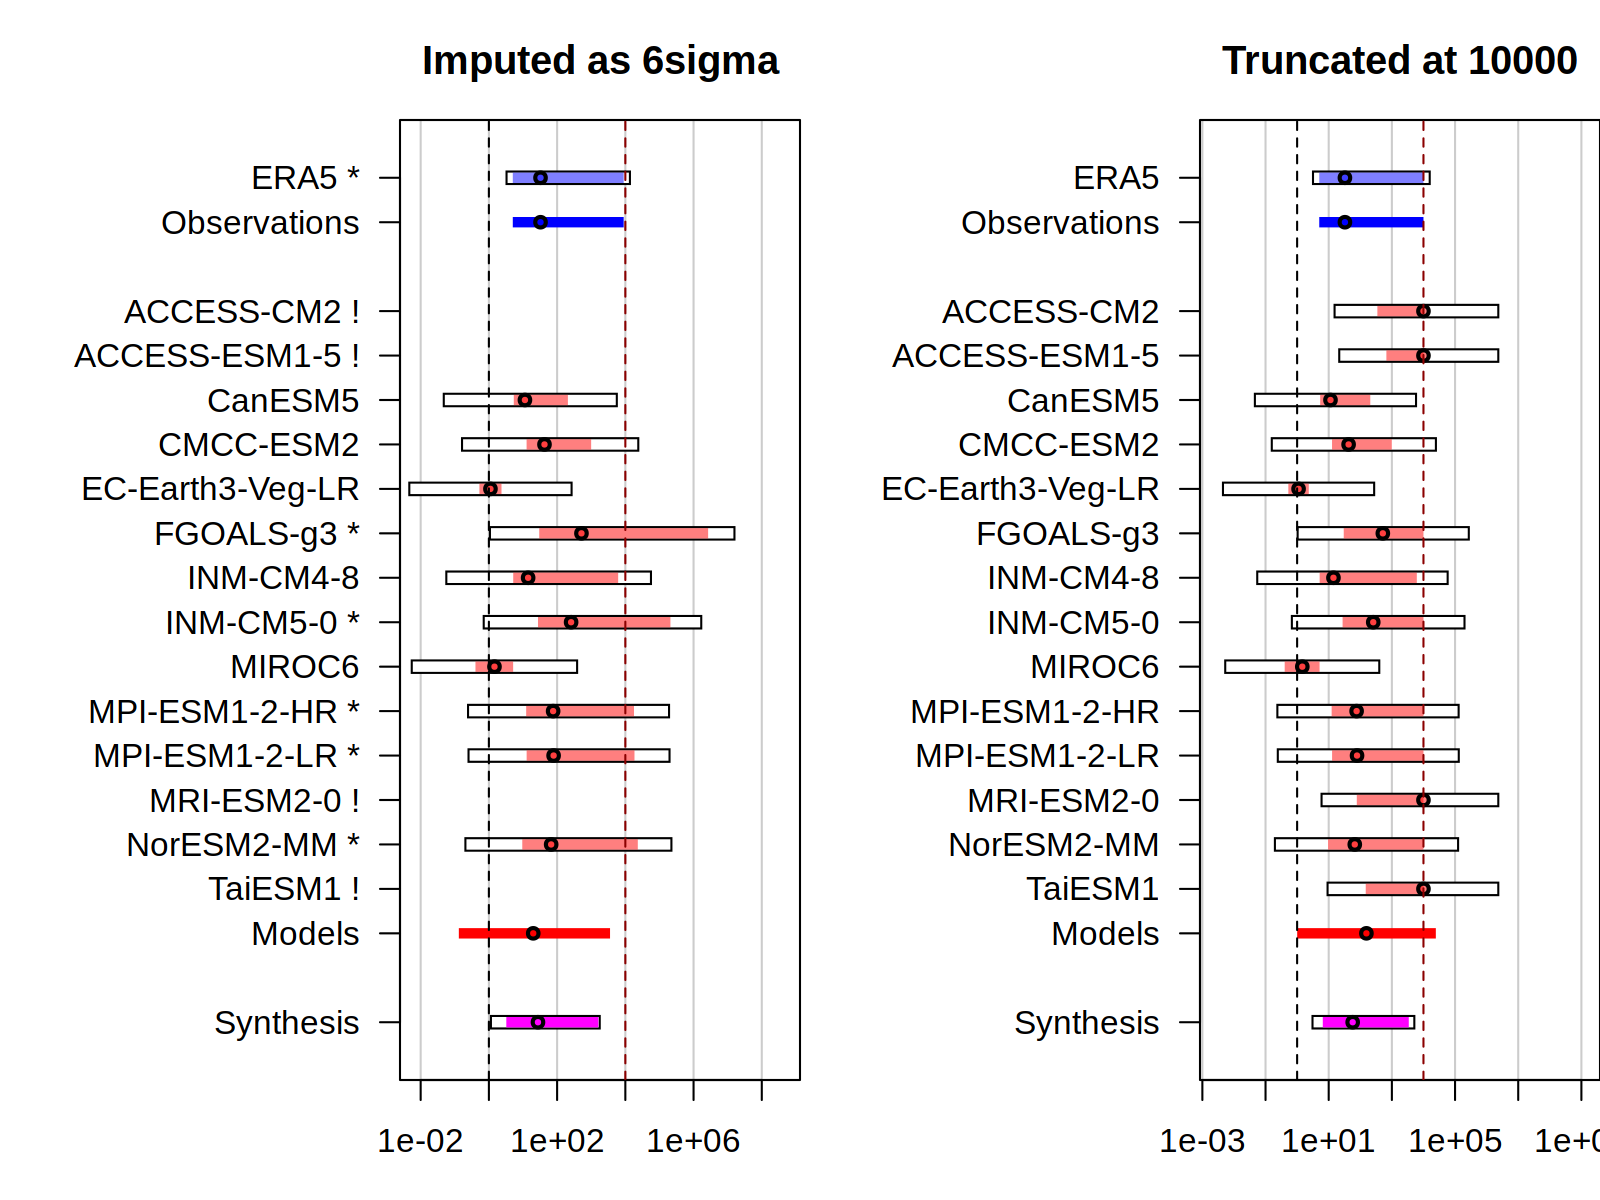

In [457]:
prep_window(c(1.5,2))
# png(paste0("fig/pr-truncated-synthesis_",study,".png"), height = 480, width =480*2); par(cex.main = 1.4); {
    par(mfrow = c(1,2), mar = c(3,10,3,0))
    plot_synthesis(synth_6sigma(synth_in[["obs_in"]], synth_in[["models_in"]], take_logs = T), main = "Imputed as 6sigma", vline = 1)
    fix_xlims <- 10^(par("usr")[1:2])
    abline(v = 10000, col = "darkred", lty = 2)
    
    plot_synthesis(synth_cx(synth_in[["obs_in"]], synth_in[["models_in"]], take_logs = T), main = "Truncated at 10000", vline = 1, xlim = fix_xlims)
    abline(v = 10000, col = "darkred", lty = 2)
    # rows marked * have had infinite upper bounds imputed; rows marked ! have had both the best estimate and the upper bound imputed
# }; dev.off()

In [452]:
synth_in[["obs_in"]]

,y0,y1,est,lower,upper,ci,model,m2,m3
,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>
1,1900,2020,32.613,5.0204,10000,95,ERA5,,


In [ ]:
res <- synth_6sigma(synth_in[["obs_in"]], synth_in[["models_in"]], take_logs = T)$df

[1] 1.613510 3.484711 9.098315
    y0   y1      est   lower    upper ci  model m2 m3
1 1900 2020 3.484711 1.61351 9.098315 95 ERA5 *      
[1] 6.507051e+00 6.507051e+04 6.507051e+08
     y0   y1          est      lower        upper ci            model
2  1900 2020 6.507051e+08  5.8501112 2.602820e+09 95     ACCESS-CM2 !
3  1900 2020 6.507051e+08  6.5070508 2.602820e+09 95  ACCESS-ESM1-5 !
4  1900 2020 2.432911e+00  1.6804554 5.333197e+00 95          CanESM5
5  1900 2020 3.752933e+00  2.5452175 6.902334e+00 95        CMCC-ESM2
6  1900 2020 1.052605e-01 -0.6405547 8.510053e-01 95 EC-Earth3-Veg-LR
7  1900 2020 6.248403e+00  3.3983600 1.479853e+01 95      FGOALS-g3 *
8  1900 2020 2.648654e+00  1.6424858 8.725841e+00 95        INM-CM4-8
9  1900 2020 5.549411e+00  3.3148403 1.225312e+01 95      INM-CM5-0 *
10 1900 2020 3.770656e-01 -0.9063404 1.636859e+00 95           MIROC6
11 1900 2020 4.336218e+00  2.5166475 9.794930e+00 95  MPI-ESM1-2-HR *
12 1900 2020 4.368245e+00  2.5485072 9.827457e+0

In [323]:
mdl <- res[res$group == "models",]

In [324]:
mdl$lower / mdl$est

[1] 1.310870e-01 4.049381e-07 1.758649e-02 1.765029e-09 1.320671e-01
 [6] 1.982343e-01 4.191683e-01 4.280553e-09 5.689553e-02 4.049381e-07
[11] 4.049381e-07 3.849384e-02 1.162483e-02 7.340047e-02 4.049381e-07
[16] 3.690903e-09 2.840435e-09 7.398259e-03